In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import os 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import geopandas as gpd
import contextily as ctx

In [2]:
yesterday_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')
yesterday_date

'2024-03-20'

In [3]:
dialect = 'mysql+pymysql'
user = 'root'
password = os.getenv('mdp_mySQL')
host = 'localhost'
port = 3306
database_idf = 'SNCF_TGV_TER'

engine_url = f"{dialect}://{user}:{password}@{host}:{port}/{database_idf}"
engine = create_engine(engine_url)

In [4]:
query_disruption = f"""
SELECT * FROM disruptions_tgv_ter
WHERE data_date = '{yesterday_date}'
"""

df_disruption = pd.read_sql_query(query_disruption, engine)
df_disruption

,id_disruption,vehicle_id,train_type,id_stop,name_stop,lon,lat,disruption_start,disruption_end,arrival_delay,departure_delay,cause_delay,data_date
0,52ba11b8-436c-4112-b1c7-d464edb6adb7,SNCF:2024-03-20:12258:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-20 13:46:00,2024-03-20 16:18:00,25.0,25.0,Panne d'un aiguillage,2024-03-20
1,52ba11b8-436c-4112-b1c7-d464edb6adb7,SNCF:2024-03-20:12258:1187:LongDistanceTrain,TGV,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-20 13:46:00,2024-03-20 16:18:00,0.0,0.0,Panne d'un aiguillage,2024-03-20
2,b77b9832-e57b-4f9d-881f-4da5626832d4,SNCF:2024-03-20:12270:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-20 19:46:00,2024-03-20 22:00:00,5.0,5.0,Travaux sur les voies,2024-03-20
3,b77b9832-e57b-4f9d-881f-4da5626832d4,SNCF:2024-03-20:12270:1187:LongDistanceTrain,TGV,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-20 19:46:00,2024-03-20 22:00:00,5.0,5.0,Travaux sur les voies,2024-03-20
4,507b8cd0-3d7e-40e5-b9d0-62113dbec29c,SNCF:2024-03-20:13113:1187:Train,TER / Intercités,stop_point:SNCF:87381509:Train,Mantes-la-Jolie,1.703370,48.9898,2024-03-20 08:14:00,2024-03-20 09:51:00,5.0,5.0,Régulation du trafic,2024-03-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5865,47cefd07-d487-41d4-b086-de7ceb1dccc9,SNCF:2024-03-20:9866:1187:LongDistanceTrain,TGV,stop_point:SNCF:87318964:LongDistanceTrain,Avignon TGV,4.786140,43.9219,2024-03-20 12:14:00,2024-03-20 17:58:00,5.0,5.0,Régulation du trafic,2024-03-20
5866,47cefd07-d487-41d4-b086-de7ceb1dccc9,SNCF:2024-03-20:9866:1187:LongDistanceTrain,TGV,stop_point:SNCF:87319012:LongDistanceTrain,Aix-en-Provence TGV,5.317530,43.4552,2024-03-20 12:14:00,2024-03-20 17:58:00,5.0,5.0,Régulation du trafic,2024-03-20
5867,47cefd07-d487-41d4-b086-de7ceb1dccc9,SNCF:2024-03-20:9866:1187:LongDistanceTrain,TGV,stop_point:SNCF:87723197:LongDistanceTrain,Lyon Part Dieu,4.859410,45.7606,2024-03-20 12:14:00,2024-03-20 17:58:00,10.0,5.0,Régulation du trafic,2024-03-20
5868,47cefd07-d487-41d4-b086-de7ceb1dccc9,SNCF:2024-03-20:9866:1187:LongDistanceTrain,TGV,stop_point:SNCF:87751008:LongDistanceTrain,Marseille Saint-Charles,5.380410,43.3027,2024-03-20 12:14:00,2024-03-20 17:58:00,0.0,0.0,Régulation du trafic,2024-03-20


In [5]:
query_vehicle = f"""
SELECT * FROM vehicle_journeys_tgv_ter
WHERE data_date = '{yesterday_date}'
"""

df_vehicle = pd.read_sql_query(query_vehicle, engine)
df_vehicle

,vehicle_id,route_id,time_begin,time_end,train_type,id_disruption,data_date
0,vehicle_journey:SNCF:2024-03-20:12244:1187:Lon...,route:SNCF:CSR:421400,0 days 18:46:00,0 days 20:59:00,Train grande vitesse,None,2024-03-20
1,vehicle_journey:SNCF:2024-03-20:12251:1187:Lon...,route:SNCF:CSR:421400,0 days 07:04:00,0 days 09:14:00,Train grande vitesse,None,2024-03-20
2,vehicle_journey:SNCF:2024-03-20:12254:1187:Lon...,route:SNCF:CSR:421400,0 days 10:46:00,0 days 12:53:00,Train grande vitesse,None,2024-03-20
3,vehicle_journey:SNCF:2024-03-20:12255:1187:Lon...,route:SNCF:CSR:421400,0 days 11:04:00,0 days 13:14:00,Train grande vitesse,None,2024-03-20
4,vehicle_journey:SNCF:2024-03-20:12258:1187:Lon...,route:SNCF:CSR:421400,0 days 13:46:00,0 days 15:53:00,Train grande vitesse,52ba11b8-436c-4112-b1c7-d464edb6adb7,2024-03-20
...,...,...,...,...,...,...,...
8917,vehicle_journey:SNCF:2024-03-20:9890:1187:Long...,route:SNCF:CSR:005400,0 days 05:59:00,0 days 09:43:00,Train grande vitesse,None,2024-03-20
8918,vehicle_journey:SNCF:2024-03-20:9894:1187:Long...,route:SNCF:CSR:005400,0 days 17:01:00,0 days 21:01:00,Train grande vitesse,None,2024-03-20
8919,vehicle_journey:SNCF:2024-03-20:9896:1187:Long...,route:SNCF:CSR:071100,0 days 15:56:00,0 days 23:49:00,Train grande vitesse,None,2024-03-20
8920,vehicle_journey:SNCF:2024-03-20:9898:1187:Long...,route:SNCF:CSR:071200,0 days 06:31:00,0 days 14:15:00,Train grande vitesse,None,2024-03-20


In [6]:
df_lines = pd.read_sql_table('pt_lines_tgv_ter', engine)
df_lines

,route_id,route_name,train_type,network_name,opening_time,closing_time
0,route:SNCF:0018-80100537-87271007,Dortmund Hbf - Paris Nord,Train grande vitesse,Eurostar,05:18:00,12:21:00
1,route:SNCF:0018-80101840-87271007,Essen Hbf - Paris Nord,Train grande vitesse,Eurostar,07:35:00,22:14:00
2,route:SNCF:0018-80154583-87271007,Köln - Hauptbahnhof - Paris Nord,Train grande vitesse,Eurostar,05:21:00,23:14:00
3,route:SNCF:0018-84000588-87111849,Amsterdam Centraal - Marne-la-Vallée - Chessy,Train grande vitesse,Eurostar,06:47:00,11:05:00
4,route:SNCF:0018-84000588-87271007,Amsterdam Centraal - Paris Nord,Train grande vitesse,Eurostar,06:11:00,23:43:00
...,...,...,...,...,...,...
363,route:stop_area:SNCF:87113001_stop_area:SNCF:8...,Paris Est - Strasbourg,Train grande vitesse,additional service,None,None
364,route:stop_area:SNCF:87394007_stop_area:SNCF:8...,Chartres - Versailles Chantiers,Train grande vitesse,additional service,None,None
365,route:stop_area:SNCF:87411017_stop_area:SNCF:8...,Rouen Rive Droite - Paris Saint-Lazare,Train grande vitesse,additional service,None,None
366,route:stop_area:SNCF:87411017_stop_area:SNCF:8...,Rouen Rive Droite - Le Havre,Train grande vitesse,additional service,None,None


# NOMBRE DE PERTURBATION

In [7]:
nb_disruption = len(df_disruption['id_disruption'].unique())
print("nombre de perturbation : " + str(nb_disruption))

nombre de perturbation : 675


# POURCENTAGE TRAJET IMPACTE

In [8]:
nb_vehicle_journeys = len(df_vehicle)
print("nombre de trajet : " + str(nb_vehicle_journeys))

impacted_journeys = df_vehicle['id_disruption'].notnull().sum()
print("nombre de trajet impacté : " + str(impacted_journeys))

per_impacted = impacted_journeys/nb_vehicle_journeys*100
print("pourcentage de trajet impacté : " + str(round(per_impacted,2)) + "%")

nombre de trajet : 8922
nombre de trajet impacté : 1219
pourcentage de trajet impacté : 13.66%


# Temps total de perturbation


In [9]:
df_disruption['duration'] = df_disruption['disruption_end'] - df_disruption['disruption_start']
df_disruption_unique = df_disruption[~df_disruption.duplicated(subset=['id_disruption'], keep='first')]
total_disruption_duration =  df_disruption_unique['duration'].sum()
print("temps cumulé de perturbation : " +  str(total_disruption_duration))

temps cumulé de perturbation : 53 days 07:44:30


# Information sur la première perturbation de la journée

In [10]:
df_vehicle['vehicle_id'] = df_vehicle['vehicle_id'].apply(lambda x: ':'.join(x.split(':')[1:]))
df_vehicle

,vehicle_id,route_id,time_begin,time_end,train_type,id_disruption,data_date
0,SNCF:2024-03-20:12244:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 18:46:00,0 days 20:59:00,Train grande vitesse,None,2024-03-20
1,SNCF:2024-03-20:12251:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 07:04:00,0 days 09:14:00,Train grande vitesse,None,2024-03-20
2,SNCF:2024-03-20:12254:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 10:46:00,0 days 12:53:00,Train grande vitesse,None,2024-03-20
3,SNCF:2024-03-20:12255:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 11:04:00,0 days 13:14:00,Train grande vitesse,None,2024-03-20
4,SNCF:2024-03-20:12258:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 13:46:00,0 days 15:53:00,Train grande vitesse,52ba11b8-436c-4112-b1c7-d464edb6adb7,2024-03-20
...,...,...,...,...,...,...,...
8917,SNCF:2024-03-20:9890:1187:LongDistanceTrain,route:SNCF:CSR:005400,0 days 05:59:00,0 days 09:43:00,Train grande vitesse,None,2024-03-20
8918,SNCF:2024-03-20:9894:1187:LongDistanceTrain,route:SNCF:CSR:005400,0 days 17:01:00,0 days 21:01:00,Train grande vitesse,None,2024-03-20
8919,SNCF:2024-03-20:9896:1187:LongDistanceTrain,route:SNCF:CSR:071100,0 days 15:56:00,0 days 23:49:00,Train grande vitesse,None,2024-03-20
8920,SNCF:2024-03-20:9898:1187:LongDistanceTrain,route:SNCF:CSR:071200,0 days 06:31:00,0 days 14:15:00,Train grande vitesse,None,2024-03-20


In [11]:
df_merge_inter = pd.merge(df_disruption, df_vehicle[['route_id', 'vehicle_id']], on='vehicle_id', how='left')
df_disruption_merge = pd.merge(df_merge_inter, df_lines[['route_id', 'route_name', 'network_name']], on='route_id', how='left')
df_disruption_merge

,id_disruption,vehicle_id,train_type,id_stop,name_stop,lon,lat,disruption_start,disruption_end,arrival_delay,departure_delay,cause_delay,data_date,duration,route_id,route_name,network_name
0,52ba11b8-436c-4112-b1c7-d464edb6adb7,SNCF:2024-03-20:12258:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-20 13:46:00,2024-03-20 16:18:00,25.0,25.0,Panne d'un aiguillage,2024-03-20,0 days 02:32:00,route:SNCF:CSR:421400,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
1,52ba11b8-436c-4112-b1c7-d464edb6adb7,SNCF:2024-03-20:12258:1187:LongDistanceTrain,TGV,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-20 13:46:00,2024-03-20 16:18:00,0.0,0.0,Panne d'un aiguillage,2024-03-20,0 days 02:32:00,route:SNCF:CSR:421400,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
2,b77b9832-e57b-4f9d-881f-4da5626832d4,SNCF:2024-03-20:12270:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-20 19:46:00,2024-03-20 22:00:00,5.0,5.0,Travaux sur les voies,2024-03-20,0 days 02:14:00,route:SNCF:CSR:421400,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
3,b77b9832-e57b-4f9d-881f-4da5626832d4,SNCF:2024-03-20:12270:1187:LongDistanceTrain,TGV,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-20 19:46:00,2024-03-20 22:00:00,5.0,5.0,Travaux sur les voies,2024-03-20,0 days 02:14:00,route:SNCF:CSR:421400,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
4,507b8cd0-3d7e-40e5-b9d0-62113dbec29c,SNCF:2024-03-20:13113:1187:Train,TER / Intercités,stop_point:SNCF:87381509:Train,Mantes-la-Jolie,1.703370,48.9898,2024-03-20 08:14:00,2024-03-20 09:51:00,5.0,5.0,Régulation du trafic,2024-03-20,0 days 01:37:00,route:SNCF:FR:Line::97E911FA-C8F2-4861-AD3C-C3...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5865,47cefd07-d487-41d4-b086-de7ceb1dccc9,SNCF:2024-03-20:9866:1187:LongDistanceTrain,TGV,stop_point:SNCF:87318964:LongDistanceTrain,Avignon TGV,4.786140,43.9219,2024-03-20 12:14:00,2024-03-20 17:58:00,5.0,5.0,Régulation du trafic,2024-03-20,0 days 05:44:00,route:SNCF:CSR:001200,Marseille Saint-Charles - Bruxelles-Midi / Bru...,TGV INOUI
5866,47cefd07-d487-41d4-b086-de7ceb1dccc9,SNCF:2024-03-20:9866:1187:LongDistanceTrain,TGV,stop_point:SNCF:87319012:LongDistanceTrain,Aix-en-Provence TGV,5.317530,43.4552,2024-03-20 12:14:00,2024-03-20 17:58:00,5.0,5.0,Régulation du trafic,2024-03-20,0 days 05:44:00,route:SNCF:CSR:001200,Marseille Saint-Charles - Bruxelles-Midi / Bru...,TGV INOUI
5867,47cefd07-d487-41d4-b086-de7ceb1dccc9,SNCF:2024-03-20:9866:1187:LongDistanceTrain,TGV,stop_point:SNCF:87723197:LongDistanceTrain,Lyon Part Dieu,4.859410,45.7606,2024-03-20 12:14:00,2024-03-20 17:58:00,10.0,5.0,Régulation du trafic,2024-03-20,0 days 05:44:00,route:SNCF:CSR:001200,Marseille Saint-Charles - Bruxelles-Midi / Bru...,TGV INOUI
5868,47cefd07-d487-41d4-b086-de7ceb1dccc9,SNCF:2024-03-20:9866:1187:LongDistanceTrain,TGV,stop_point:SNCF:87751008:LongDistanceTrain,Marseille Saint-Charles,5.380410,43.3027,2024-03-20 12:14:00,2024-03-20 17:58:00,0.0,0.0,Régulation du trafic,2024-03-20,0 days 05:44:00,route:SNCF:CSR:001200,Marseille Saint-Charles - Bruxelles-Midi / Bru...,TGV INOUI


In [12]:
index_first_disruption = df_disruption_merge.loc[df_disruption_merge['disruption_start'] >= yesterday_date]['disruption_start'].idxmin()

hour_first_disruption = df_disruption_merge['disruption_start'][index_first_disruption]
print("horraire de la première perturbation de la journée : " + str(hour_first_disruption))

cause_first_disruption = df_disruption_merge['cause_delay'][index_first_disruption]
print("cause de la perturbation : " + str(cause_first_disruption))

route_first_disruption = df_disruption_merge['route_name'][index_first_disruption]
print("nom de la ligne impactée : " + str(route_first_disruption))

network_first_disruption = df_disruption_merge['network_name'][index_first_disruption]
print("réseau : " + str(network_first_disruption))

horraire de la première perturbation de la journée : 2024-03-20 04:48:00
cause de la perturbation : Difficultés lors de la préparation du train
nom de la ligne impactée : nan
réseau : nan


# Réseaux les plus perturbés en pourcentage (test graphique)


In [13]:
df_vehicle_merge = pd.merge(df_vehicle, df_lines[['route_id', 'route_name', 'network_name']], on='route_id', how='left')
df_vehicle_merge

,vehicle_id,route_id,time_begin,time_end,train_type,id_disruption,data_date,route_name,network_name
0,SNCF:2024-03-20:12244:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 18:46:00,0 days 20:59:00,Train grande vitesse,None,2024-03-20,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
1,SNCF:2024-03-20:12251:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 07:04:00,0 days 09:14:00,Train grande vitesse,None,2024-03-20,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
2,SNCF:2024-03-20:12254:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 10:46:00,0 days 12:53:00,Train grande vitesse,None,2024-03-20,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
3,SNCF:2024-03-20:12255:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 11:04:00,0 days 13:14:00,Train grande vitesse,None,2024-03-20,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
4,SNCF:2024-03-20:12258:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 13:46:00,0 days 15:53:00,Train grande vitesse,52ba11b8-436c-4112-b1c7-d464edb6adb7,2024-03-20,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
...,...,...,...,...,...,...,...,...,...
8917,SNCF:2024-03-20:9890:1187:LongDistanceTrain,route:SNCF:CSR:005400,0 days 05:59:00,0 days 09:43:00,Train grande vitesse,None,2024-03-20,Strasbourg - Bruxelles-Midi / Brussel-Zuid,TGV INOUI
8918,SNCF:2024-03-20:9894:1187:LongDistanceTrain,route:SNCF:CSR:005400,0 days 17:01:00,0 days 21:01:00,Train grande vitesse,None,2024-03-20,Strasbourg - Bruxelles-Midi / Brussel-Zuid,TGV INOUI
8919,SNCF:2024-03-20:9896:1187:LongDistanceTrain,route:SNCF:CSR:071100,0 days 15:56:00,0 days 23:49:00,Train grande vitesse,None,2024-03-20,Nancy - Nice,TGV INOUI
8920,SNCF:2024-03-20:9898:1187:LongDistanceTrain,route:SNCF:CSR:071200,0 days 06:31:00,0 days 14:15:00,Train grande vitesse,None,2024-03-20,Montpellier Saint-Roch - Strasbourg,TGV INOUI


In [14]:
vehicle_by_network = df_vehicle_merge.groupby('network_name')['vehicle_id'].count()

vehicle_by_network = vehicle_by_network.sort_index()

vehicle_by_network

network_name
DB SNCF                    60
Eurostar                  104
Intercités                 50
Intercités de nuit          4
LEX                       111
OUIGO                      54
OUIGO Train Classique       6
TER                      3058
TER HDF                   367
TER NA                    233
TGV INOUI                 549
TGV Lyria                  31
Name: vehicle_id, dtype: int64

In [15]:
disrupted_vehicle_by_network = df_vehicle_merge[df_vehicle_merge['id_disruption'].notna()].groupby('network_name')['vehicle_id'].count()

for name in vehicle_by_network.index:
    if not(name in disrupted_vehicle_by_network.index):
        disrupted_vehicle_by_network[name] = 0
        
disrupted_vehicle_by_network = disrupted_vehicle_by_network.sort_index()
disrupted_vehicle_by_network

network_name
DB SNCF                   12
Eurostar                   1
Intercités                 6
Intercités de nuit         0
LEX                        9
OUIGO                     19
OUIGO Train Classique      3
TER                      337
TER HDF                  134
TER NA                    29
TGV INOUI                115
TGV Lyria                  8
Name: vehicle_id, dtype: int64

In [16]:
per_disrupted_vehicle_by_network = (disrupted_vehicle_by_network/vehicle_by_network *100).where(disrupted_vehicle_by_network >= 1, 0).sort_values(ascending=True)

per_disrupted_vehicle_by_network

network_name
Intercités de nuit        0.000000
Eurostar                  0.961538
LEX                       8.108108
TER                      11.020275
Intercités               12.000000
TER NA                   12.446352
DB SNCF                  20.000000
TGV INOUI                20.947177
TGV Lyria                25.806452
OUIGO                    35.185185
TER HDF                  36.512262
OUIGO Train Classique    50.000000
Name: vehicle_id, dtype: float64

In [17]:
df_disruption_merge['time_disruption'] = df_disruption_merge['disruption_end'] - df_disruption_merge['disruption_start']

In [18]:
#Transformer en minutes éventuellement
total_delay_by_network = df_disruption_merge.drop_duplicates(['id_disruption', 'vehicle_id']).groupby('network_name')['arrival_delay'].sum()
avg_delay_by_network = total_delay_by_network/vehicle_by_network

for i in range(len(disrupted_vehicle_by_network)):
    if not(disrupted_vehicle_by_network.index[i] in total_delay_by_network.index) : 
        avg_delay_by_network[i] = 0
        
for i in range(len(avg_delay_by_network)):
    if avg_delay_by_network[i] != 0:
        avg_delay_by_network[i] = str(int(avg_delay_by_network[i]*60)) + " secondes" 
    else : 
        avg_delay_by_network[i] = "0 seconde"
    
print("temps moyen de retard par train en seconde pour chaque réseau : \n\n" + str(avg_delay_by_network))

temps moyen de retard par train en seconde pour chaque réseau : 

network_name
DB SNCF                  120 secondes
Eurostar                    0 seconde
Intercités                18 secondes
Intercités de nuit          0 seconde
LEX                       24 secondes
OUIGO                    405 secondes
OUIGO Train Classique       0 seconde
TER                       45 secondes
TER HDF                  151 secondes
TER NA                    24 secondes
TGV INOUI                 53 secondes
TGV Lyria                 96 secondes
dtype: object


In [19]:
# Je n'ai pas encore décidé des informations à présenter, c'est pourquoi il y a des répétitions
info = [vehicle_by_network,disrupted_vehicle_by_network,avg_delay_by_network,avg_delay_by_network]
info_name = ["Nombre de trajet", "Nombre de trajet \n perturbé", "Retard moyen \n par train", "?"]

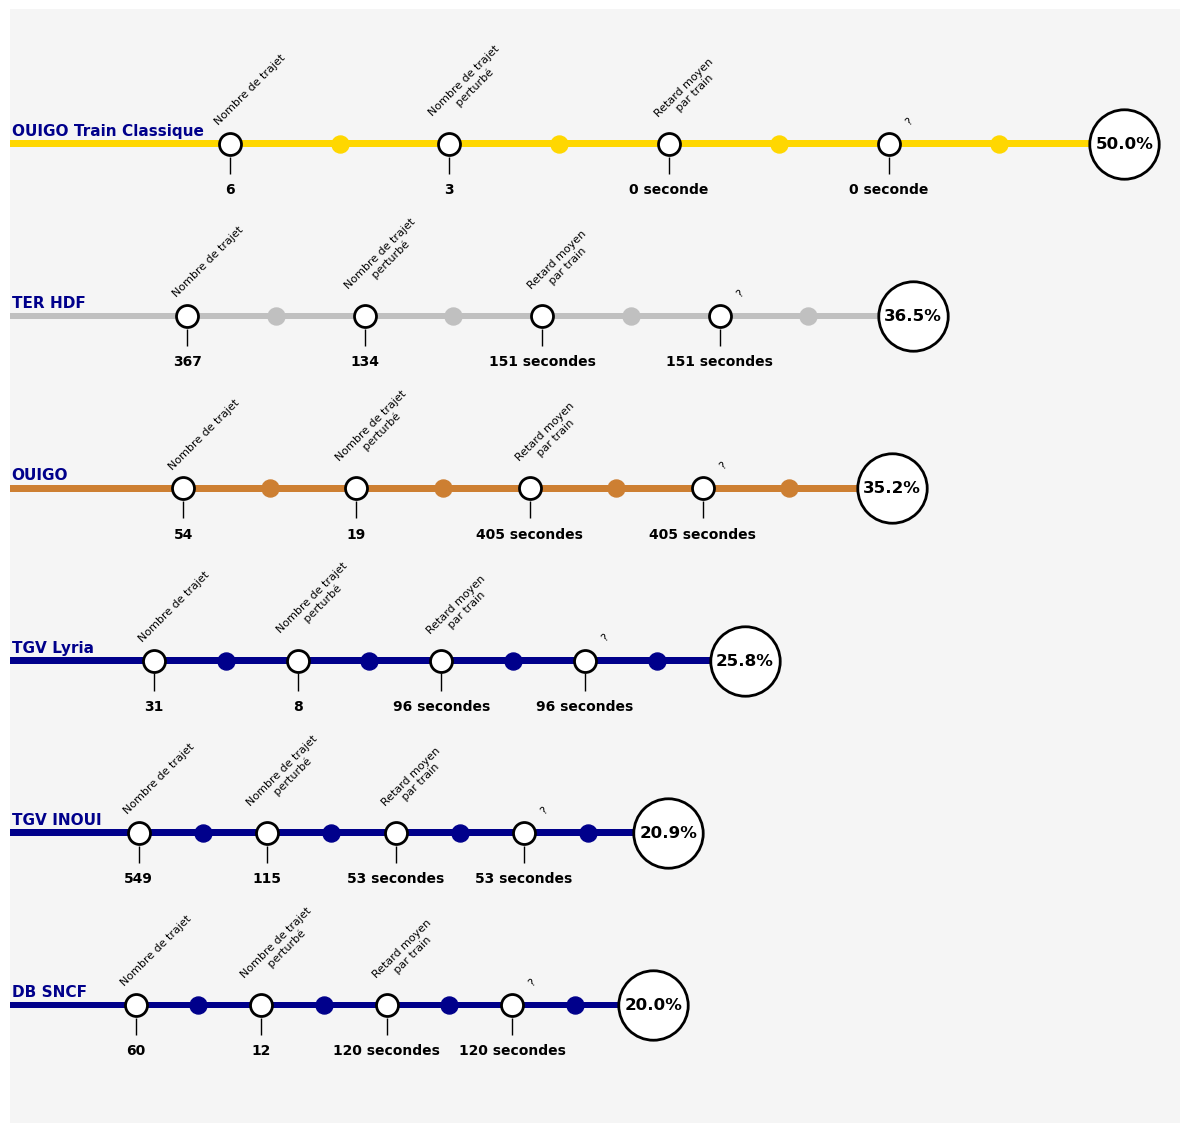

In [20]:
# Je n'ai pas encore décidé des informations à présenter, c'est pourquoi il y a des répétitions

per_disrupted_vehicle_by_network_part1 = dict(per_disrupted_vehicle_by_network[6:])

fig, ax = plt.subplots(figsize=(12, 12))

transformation = {key: (value+20)*0.1 for key, value in per_disrupted_vehicle_by_network_part1.items()}

keys = list(transformation.keys())
values = list(transformation.values())

colors = ['darkblue','darkblue','darkblue',"#CD7F32", "#C0C0C0", "#FFD700"]

bars = ax.barh(keys, values, color=colors, height=0.04)

x_positions = [value + 0.1 for value in values]

ax.scatter(x_positions, list(transformation.keys()), facecolors='white', edgecolors='black', linewidths=2, s=2500)

intervals_white = [0.2, 0.4, 0.6, 0.8]
intervals_black = [0.3, 0.5, 0.7, 0.9]

for j, (bar, new_x) in enumerate(zip(bars, x_positions)):
    y = bar.get_y() + bar.get_height() / 2
    width = bar.get_width()
    
    # Texte pour le pourcentage à droite
    ax.text(new_x, y, f'{width/0.1 - 20:.1f}%', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Placement des noms des réseaux au début de chaque barre.
    ax.text(0.01, y+0.075, keys[j], ha='left', va='center', fontsize=11, fontweight='bold', color='darkblue')
    
    for i, interval in enumerate(intervals_white):
        circle_x = width * interval
        ax.scatter(circle_x, y, facecolors='white', edgecolors='black', linewidths=2, s=250)
        
        line_start = y - 0.075
        line_end = y - 0.175
        ax.vlines(circle_x, line_start, line_end, colors='black', linewidth=1)
        
        # Texte sous la barre verticale
        text_y_position_below = line_end - 0.05
        current_info_value = info[i][keys[j]]
        ax.text(circle_x, text_y_position_below, f'{current_info_value}', ha='center', va='top', fontsize=10, fontweight='bold')
        
        # Texte au-dessus du cercle
        text_y_position_above = y + 0.1 
        above_text = info_name[i]
        ax.text(circle_x + 0.13, text_y_position_above, above_text, ha='center', va='bottom', fontsize=8, rotation=45)
        
    for interval in intervals_black:
        facecolors = colors[j]
        circle_x = width * interval
        ax.scatter(circle_x, y, facecolors=facecolors, s=150)

ax.set_title('', fontsize=22)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.set_facecolor('whitesmoke')
sns.despine(left=True, bottom=True, ax=ax, offset=10, trim=True)

plt.tight_layout()
ax.set_ylim(bottom=ax.get_ylim()[0] -0.25, top=ax.get_ylim()[1] +0.5)
plt.savefig("Perturbation_ligne_part1.png", dpi = 300)

plt.show()

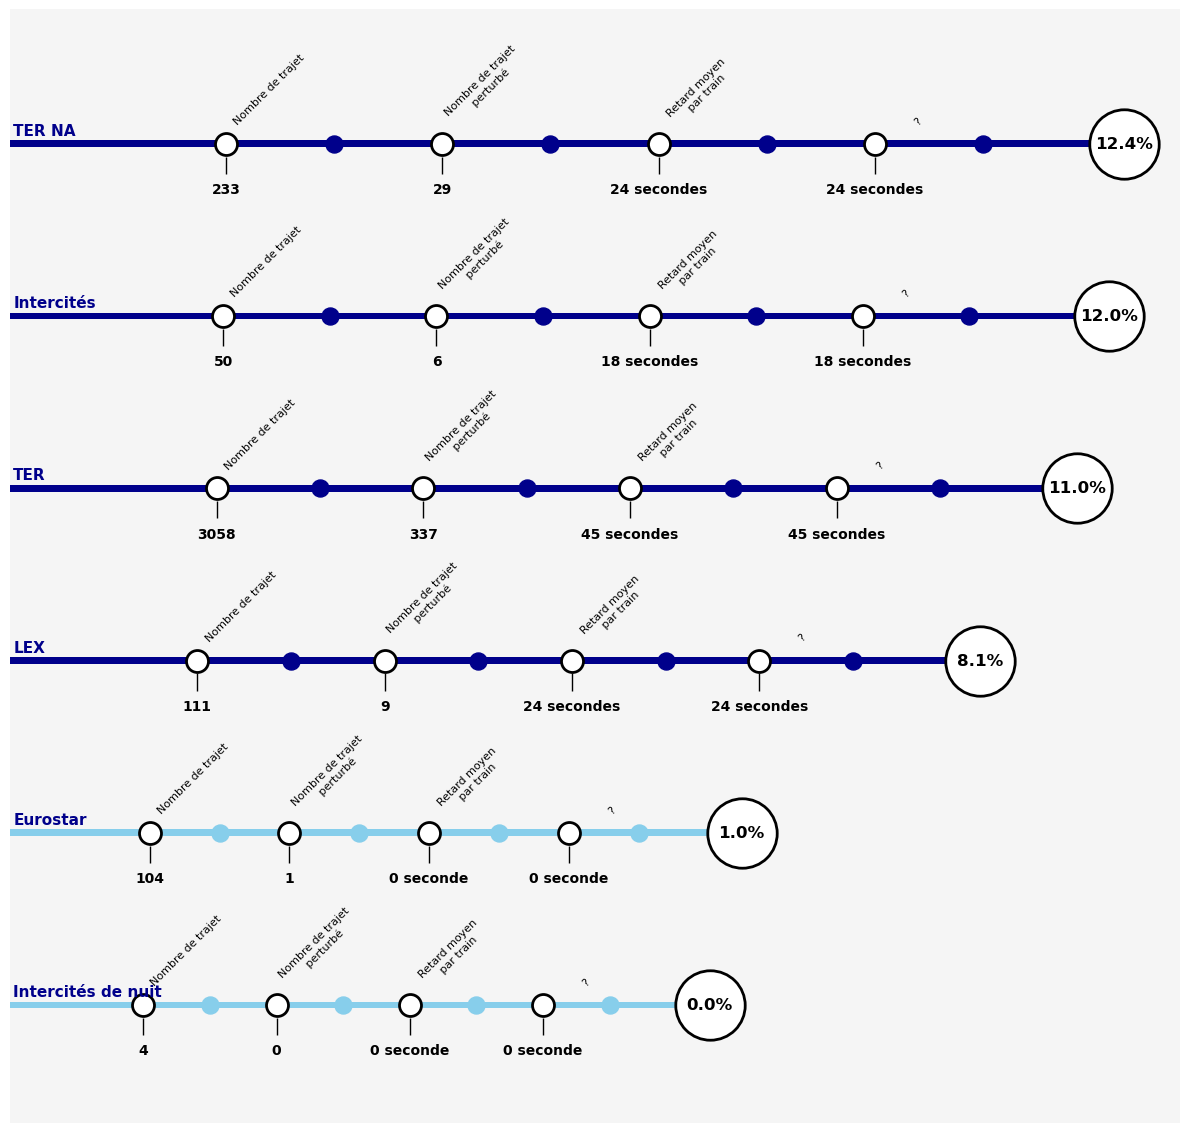

In [21]:
per_disrupted_vehicle_by_network_part2 = dict(per_disrupted_vehicle_by_network[:6])

fig, ax = plt.subplots(figsize=(12, 12))

transformation = {key: (value+20)*0.1 for key, value in per_disrupted_vehicle_by_network_part2.items()}

keys = list(transformation.keys())
values = list(transformation.values())

colors = ['skyblue', 'skyblue','darkblue','darkblue','darkblue','darkblue']

bars = ax.barh(keys, values, color=colors, height=0.04)

x_positions = [value + 0.1 for value in values]

ax.scatter(x_positions, list(transformation.keys()), facecolors='white', edgecolors='black', linewidths=2, s=2500)

intervals_white = [0.2, 0.4, 0.6, 0.8]
intervals_black = [0.3, 0.5, 0.7, 0.9]

for j, (bar, new_x) in enumerate(zip(bars, x_positions)):
    y = bar.get_y() + bar.get_height() / 2
    width = bar.get_width()
    
    # Texte pour le pourcentage à droite
    ax.text(new_x, y, f'{width/0.1 - 20:.1f}%', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Placement des noms des réseaux au début de chaque barre.
    ax.text(0.01, y+0.075, keys[j], ha='left', va='center', fontsize=11, fontweight='bold', color='darkblue')
    
    for i, interval in enumerate(intervals_white):
        circle_x = width * interval
        ax.scatter(circle_x, y, facecolors='white', edgecolors='black', linewidths=2, s=250)
        
        line_start = y - 0.075
        line_end = y - 0.175
        ax.vlines(circle_x, line_start, line_end, colors='black', linewidth=1)
        
        # Texte sous la barre verticale
        text_y_position_below = line_end - 0.05
        current_info_value = info[i][keys[j]]
        ax.text(circle_x, text_y_position_below, f'{current_info_value}', ha='center', va='top', fontsize=10, fontweight='bold')
        
        # Texte au-dessus du cercle
        text_y_position_above = y + 0.1 
        above_text = info_name[i]
        ax.text(circle_x + 0.13, text_y_position_above, above_text, ha='center', va='bottom', fontsize=8, rotation=45)
        
    for interval in intervals_black:
        facecolors = colors[j]
        circle_x = width * interval
        ax.scatter(circle_x, y, facecolors=facecolors, s=150)

ax.set_title('', fontsize=22)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.set_facecolor('whitesmoke')
sns.despine(left=True, bottom=True, ax=ax, offset=10, trim=True)

plt.tight_layout()
ax.set_ylim(bottom=ax.get_ylim()[0] -0.25, top=ax.get_ylim()[1] +0.5)
plt.savefig("Perturbation_ligne_part2.png", dpi = 300)

plt.show()

# Routes les plus perturbées en pourcentage (graphique à faire)

In [22]:
vehicle_by_route = df_vehicle_merge.groupby('route_name')['vehicle_id'].count()
vehicle_by_route = vehicle_by_route[vehicle_by_route >= 10]
vehicle_by_route

route_name
(Namur) - (Charleroi) - Maubeuge    14
Alençon - Château Du Loir           12
Ambérieu - Chambery                 12
Amsterdam Centraal - Paris Nord     11
Angers St Laud - Le Mans            25
                                    ..
Tours - Le Croisic                  16
Tours - Loches                      12
Tours - Saumur - Angers - Nantes    11
Wissembourg - Neustadt              32
YVETOT - ROUEN - ELBEUF             32
Name: vehicle_id, Length: 171, dtype: int64

In [23]:
disrupted_vehicle_by_route = df_vehicle_merge[df_vehicle_merge['id_disruption'].notna()].groupby('route_name')['vehicle_id'].count()
disrupted_vehicle_by_route

route_name
(Namur) - (Charleroi) - Maubeuge    6
11. Poitiers-Tours                  1
Alençon - Château Du Loir           1
Ambérieu - Chambery                 4
Angers St Laud - Le Mans            6
                                   ..
Tours - Saumur - Angers - Nantes    2
Tours-Voves-Chartres                2
Valenciennes - Paris Nord           5
Wissembourg - Neustadt              8
YVETOT - ROUEN - ELBEUF             1
Name: vehicle_id, Length: 192, dtype: int64

In [24]:
per_disrupted_vehicle_by_route = disrupted_vehicle_by_route/vehicle_by_route *100
winners = per_disrupted_vehicle_by_route.sort_values(ascending=True)[:10]
nb_train_winners = vehicle_by_route.loc[winners.index]
print("Les 10 lignes les moins impactées (min 10 trajets)\n\n" + str(winners) + "\n\n\n")
print("Nombre de trajet des 10 lignes les moins impactées\n\n" + str(nb_train_winners))

Les 10 lignes les moins impactées (min 10 trajets)

route_name
Lyon Perrache - Firminy                            2.222222
Strasbourg - Molsheim                              2.631579
Lauterbourg - Woerth Rhein                         2.777778
Charleville - Givet                                3.030303
YVETOT - ROUEN - ELBEUF                            3.125000
Saint-Marcellin - Grenoble Universités Gières      3.125000
Annemasse - Suisse                                 3.174603
Marseille - Miramas Via Cote Bleue                 3.333333
Avignon Tgv - Avignon Centre - Carpentras          3.571429
Paris - Montparnasse - Hall 1 & 2 - La Rochelle    3.846154
Name: vehicle_id, dtype: float64



Nombre de trajet des 10 lignes les moins impactées

route_name
Lyon Perrache - Firminy                            45
Strasbourg - Molsheim                              38
Lauterbourg - Woerth Rhein                         36
Charleville - Givet                                33
YVETOT - ROUEN - ELBEU

In [25]:
losers = per_disrupted_vehicle_by_route.sort_values(ascending=False)[:10]
nb_train_losers = vehicle_by_route.loc[losers.index]
print("Les 10 lignes les plus impactées (min 10 trajets)\n\n" + str(losers) + "\n\n\n")
print("Nombre de trajet des 10 lignes les plus impactées\n\n" + str(nb_train_losers))

Les 10 lignes les plus impactées (min 10 trajets)

route_name
C40                                                           83.720930
P42                                                           80.000000
P44                                                           70.833333
K40                                                           52.173913
Paris Est - Karlsruhe Hauptbahnhof                            50.000000
Marseille Saint-Charles - Aéroport Charles de Gaulle 2 TGV    42.857143
Montpellier Saint-Roch - Avignon Centre                       42.857143
(Namur) - (Charleroi) - Maubeuge                              42.857143
Paris Est - Frankfurt am Main - Hauptbahnhof                  41.666667
Lille Flandres - Baisieux - (Tournai)                         41.176471
Name: vehicle_id, dtype: float64



Nombre de trajet des 10 lignes les plus impactées

route_name
C40                                                           43
P42                                                    

# Arrêts le plus impactés en nombre et en temps de retard (test graphique)

--> Météo des retards

In [26]:
most_impacted_stop = df_disruption.groupby('name_stop')['vehicle_id'].count().sort_values(ascending=False)[:30]

print("Arrets les plus impactés par les perturbations : \n\n" + str(most_impacted_stop))

Arrets les plus impactés par les perturbations : 

name_stop
Lille Flandres                       88
Lyon Part Dieu                       68
Douai                                53
Strasbourg                           45
Arras                                41
Paris Nord                           40
Lyon Perrache                        40
Nantes                               40
Bordeaux Saint-Jean                  39
Marseille Saint-Charles              37
Angers Saint-Laud                    35
Toulouse Matabiau                    33
Paris - Gare de Lyon - Hall 1 & 2    31
Paris - Montparnasse - Hall 1 & 2    30
Amiens                               29
Mulhouse                             28
Dijon                                24
Metz                                 24
Le Mans                              23
La Tour-du-Pin                       22
Bourgoin-Jallieu                     22
Paris Est                            22
Nancy                                19
Grenoble           

In [27]:
stops_lon_lat = df_disruption[df_disruption['name_stop'].isin(most_impacted_stop.index)].groupby('name_stop').agg({'lon': 'first', 'lat': 'first'}).reset_index()

longitudes = list(stops_lon_lat['lon'])
latitudes = list(stops_lon_lat['lat'])

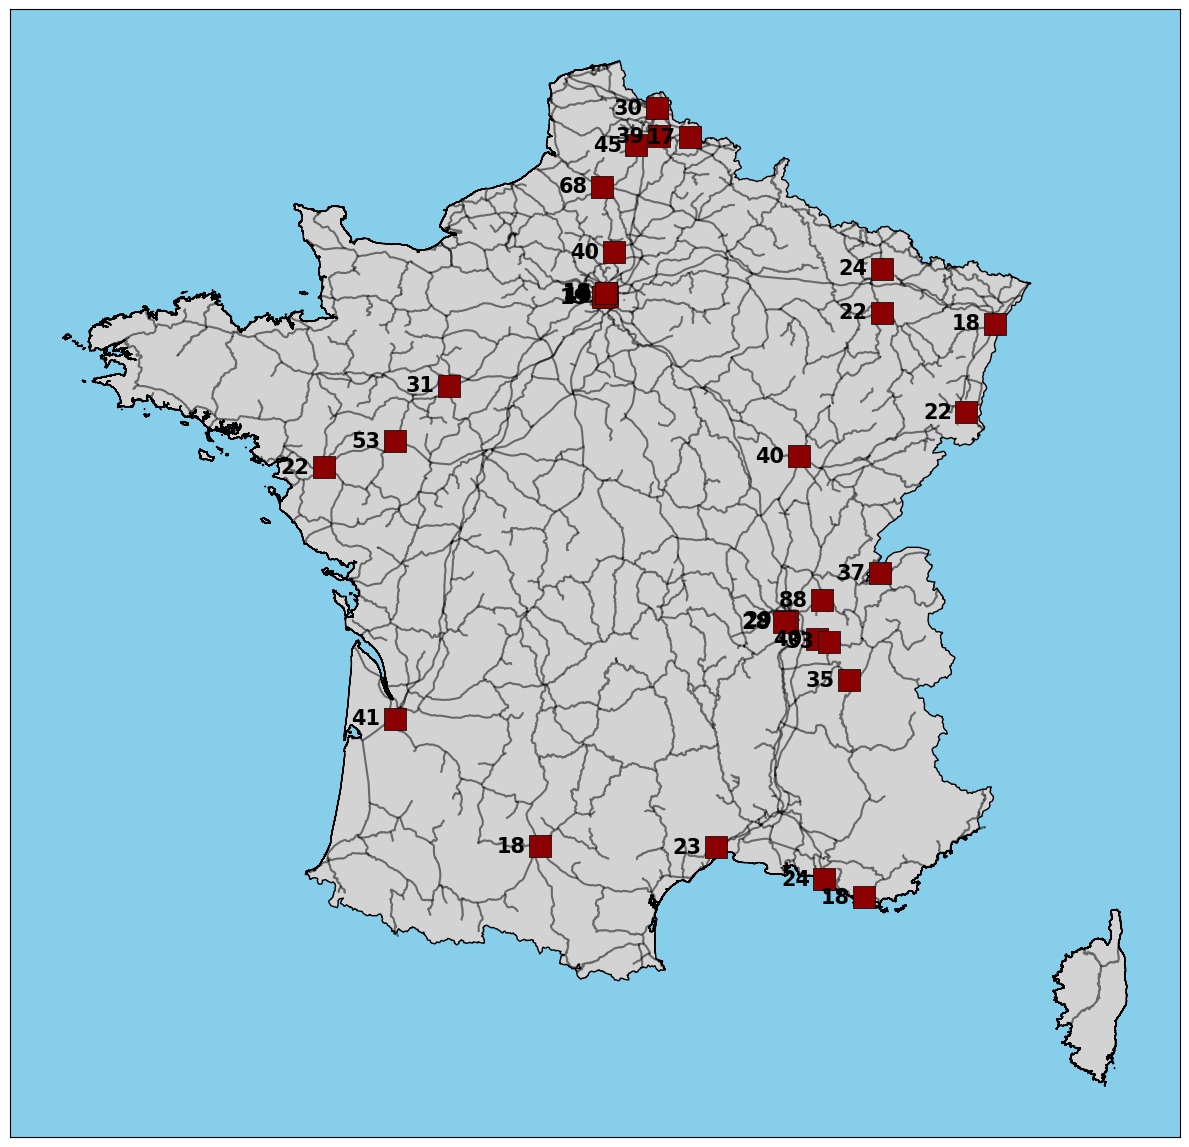

In [28]:
# Regrouper les gares d'une meme ville --> Paris/lyon plusieurs gares --> Manque de visibilité
# Utiliser premier mot de la gare ? 
# Regrouper en utilisant les données lon et lat ? 
# --> si gare meme ville faire la somme --> si gare pas meme ville mais trop proche supprimer pour rendre plus lisible 

# Chercher données lon et lat sur les routes pour pouvoir mettre en valeur les routes impactées avec echelle de couleur ?
# A merge par route_id ou route_name 


fig, ax = plt.subplots(figsize=(12, 12))

reseau = gpd.read_file('formes-des-lignes-du-rfn/formes-des-lignes-du-rfn.shp')
france = gpd.read_file('data/FRA_adm0.shp')

ax.set_facecolor('skyblue')

france.plot(ax=ax, color='lightgrey', edgecolor='black') 
reseau.plot(ax=ax, color='black', alpha=0.5)  

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Tracer les points
ax.scatter(longitudes, latitudes, s=250, color='darkred', edgecolor='black', linewidth=0.5, zorder=3, alpha=1, marker='s')

# Ajouter du texte à gauche de chaque carré --> mettre texte a gauche ou à droite selon ce qu'il y a autour 
# Mettre en rouge la valeur la plus élevé et en bleu la moins élevé
for lon, lat, value in zip(longitudes, latitudes, list(most_impacted_stop)): 
    ax.text(lon - 0.6, lat, str(value), verticalalignment='center', fontsize=15, color='black', fontweight='bold')

plt.tight_layout()
plt.savefig("Meteo_retard_ameliore.png", dpi=300)

plt.show()

### Regroupement ville/gare tres proche

In [29]:
most_impacted_stop =  most_impacted_stop.sort_index()
most_impacted_stop_new = {}
name_to_ereased = []

for i in range(len(most_impacted_stop)):
    count_disruption_city = most_impacted_stop.iloc[i]

    for j in range(i + 1, len(most_impacted_stop)):
        if (int(stops_lon_lat['lon'].iloc[i] * 10) / 10 == int(stops_lon_lat['lon'].iloc[j] * 10) / 10) and \
           (int(stops_lon_lat['lat'].iloc[i] * 10) / 10 == int(stops_lon_lat['lat'].iloc[j] * 10) / 10):
            count_disruption_city += most_impacted_stop.iloc[j]        
            name_to_ereased.append(most_impacted_stop.index[j])
    
    most_impacted_stop_new[most_impacted_stop.index[i]] = count_disruption_city    
    
most_impacted_stop_new = pd.Series(most_impacted_stop_new, name="Total Disruptions").drop(name_to_ereased)
most_impacted_stop_new

Ambérieu-en-Bugey                     17
Amiens                                29
Angers Saint-Laud                     35
Arras                                 41
Bordeaux Saint-Jean                   39
Bourgoin-Jallieu                      22
Creil                                 18
Dijon                                 24
Douai                                 53
Genève Cornavin                       18
Grenoble                              19
La Tour-du-Pin                        22
Le Mans                               23
Lille Flandres                        88
Lyon Part Dieu                       108
Marseille Saint-Charles               37
Metz                                  24
Montpellier Saint-Roch                18
Mulhouse                              28
Nancy                                 19
Nantes                                40
Paris - Gare de Lyon - Hall 1 & 2    123
Strasbourg                            45
Toulon                                19
Toulouse Matabia

In [30]:
stops_lon_lat_new = df_disruption[df_disruption['name_stop'].isin(most_impacted_stop_new.index)].groupby('name_stop').agg({'lon': 'first', 'lat': 'first'}).reset_index()

longitudes_new = list(stops_lon_lat_new['lon'])
latitudes_new = list(stops_lon_lat_new['lat'])

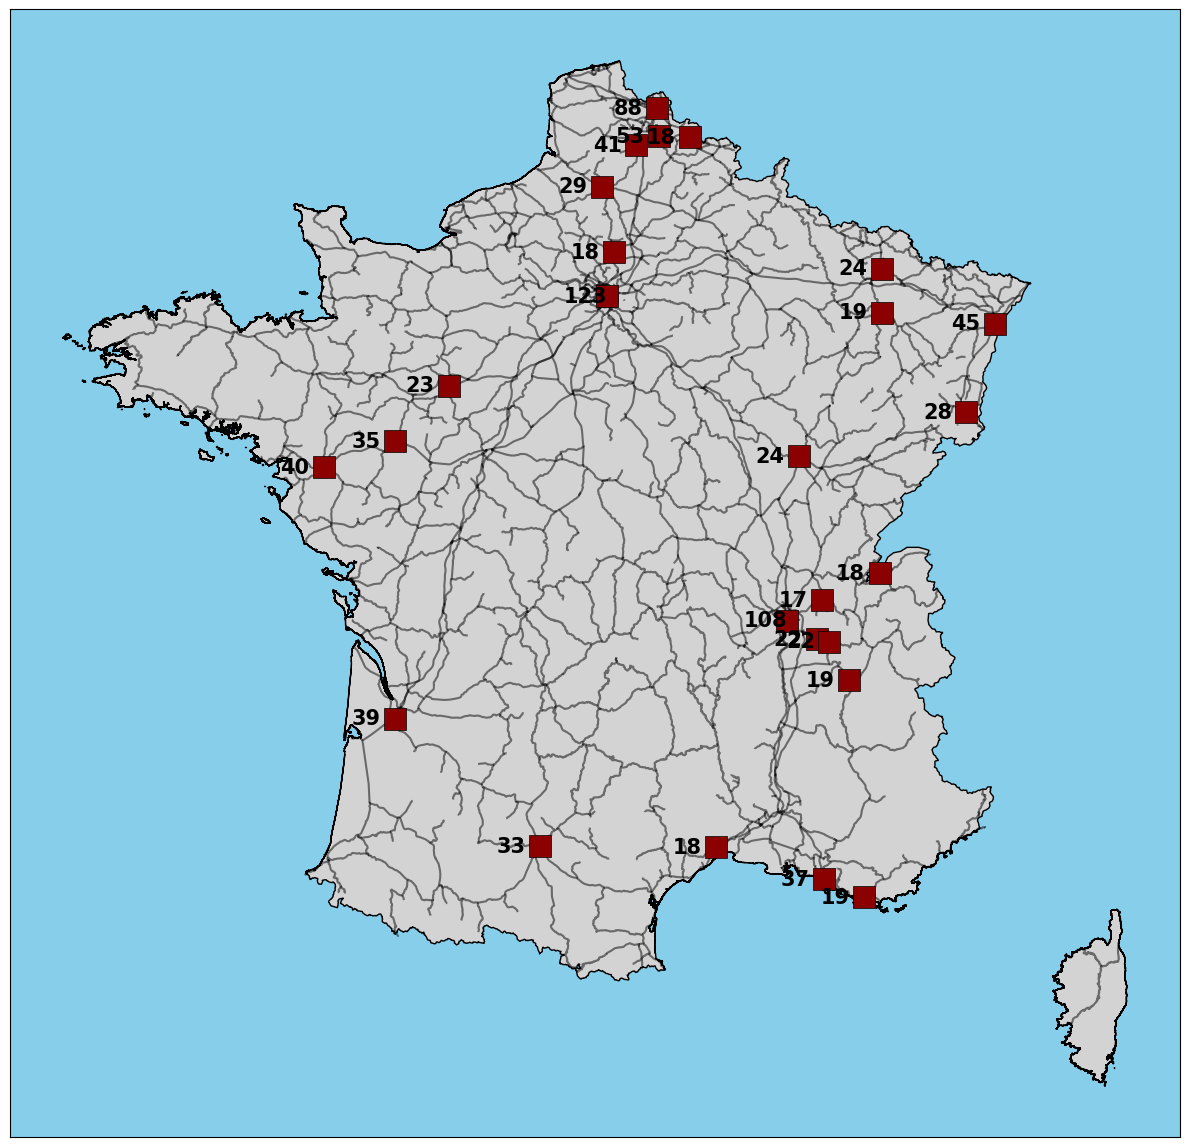

In [31]:
fig, ax = plt.subplots(figsize=(12, 12))

reseau = gpd.read_file('formes-des-lignes-du-rfn/formes-des-lignes-du-rfn.shp')
france = gpd.read_file('data/FRA_adm0.shp')

ax.set_facecolor('skyblue')

france.plot(ax=ax, color='lightgrey', edgecolor='black') 
reseau.plot(ax=ax, color='black', alpha=0.5)  

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Tracer les points
ax.scatter(longitudes_new, latitudes_new, s=250, color='darkred', edgecolor='black', linewidth=0.5, zorder=3, alpha=1, marker='s')

# Ajouter du texte à gauche de chaque carré --> mettre texte a gauche ou à droite selon ce qu'il y a autour 
# Mettre en rouge la valeur la plus élevé et en bleu la moins élevé
for lon, lat, value in zip(longitudes_new, latitudes_new, list(most_impacted_stop_new)): 
    ax.text(lon - 0.6, lat, str(value), verticalalignment='center', fontsize=15, color='black', fontweight='bold')

plt.tight_layout()
plt.savefig("Meteo_retard_ameliore.png", dpi=300)

plt.show()

### Suppression de la gare la moins perturbée quand regroupement de gare proche mais pas suffisement pour former un meme point

In [32]:
name_to_erase = []

for i in range(len(most_impacted_stop_new)):
    list_stop = [(most_impacted_stop_new.index[i], most_impacted_stop_new.iloc[i])]
    for j in range(i + 1, len(most_impacted_stop_new)):
        if abs(stops_lon_lat_new['lon'].iloc[i] - stops_lon_lat_new['lon'].iloc[j]) < 0.5 and \
           abs(stops_lon_lat_new['lat'].iloc[i] - stops_lon_lat_new['lat'].iloc[j]) < 0.5:
            list_stop.append((most_impacted_stop_new.index[j], most_impacted_stop_new.iloc[j]))
    
    if len(list_stop) > 1:
        list_stop.sort(key=lambda x: x[1])
        name_to_erase.extend([idx for idx, _ in list_stop[:-1]])

name_to_erase = list(set(name_to_erase))

most_impacted_stop_new_V2 = most_impacted_stop_new.drop(name_to_erase)

most_impacted_stop_new_V2


Angers Saint-Laud                     35
Bordeaux Saint-Jean                   39
Dijon                                 24
Genève Cornavin                       18
Le Mans                               23
Lille Flandres                        88
Lyon Part Dieu                       108
Marseille Saint-Charles               37
Metz                                  24
Montpellier Saint-Roch                18
Mulhouse                              28
Nantes                                40
Paris - Gare de Lyon - Hall 1 & 2    123
Strasbourg                            45
Toulon                                19
Toulouse Matabiau                     33
Name: Total Disruptions, dtype: int64

In [33]:
stops_lon_lat_new_v2 = df_disruption[df_disruption['name_stop'].isin(most_impacted_stop_new_V2.index)].groupby('name_stop').agg({'lon': 'first', 'lat': 'first'}).reset_index()

longitudes_new_v2 = list(stops_lon_lat_new_v2['lon'])
latitudes_new_v2 = list(stops_lon_lat_new_v2['lat'])

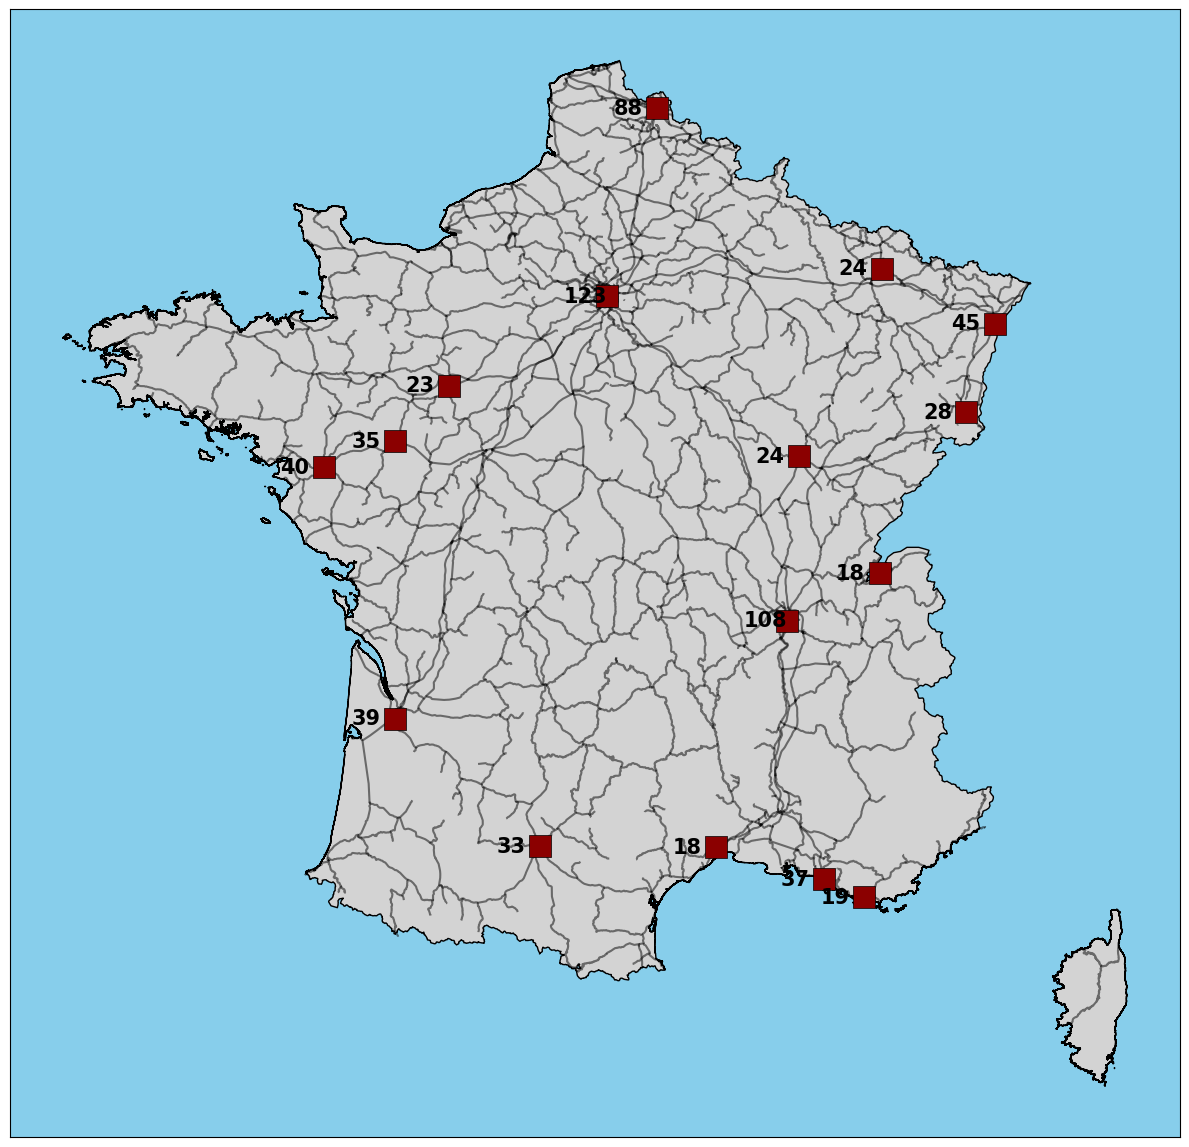

In [34]:
fig, ax = plt.subplots(figsize=(12, 12))

reseau = gpd.read_file('formes-des-lignes-du-rfn/formes-des-lignes-du-rfn.shp')
france = gpd.read_file('data/FRA_adm0.shp')

ax.set_facecolor('skyblue')

france.plot(ax=ax, color='lightgrey', edgecolor='black') 
reseau.plot(ax=ax, color='black', alpha=0.5)  

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Tracer les points
ax.scatter(longitudes_new_v2, latitudes_new_v2, s=250, color='darkred', edgecolor='black', linewidth=0.5, zorder=3, alpha=1, marker='s')

# Ajouter du texte à gauche de chaque carré --> mettre texte a gauche ou à droite selon ce qu'il y a autour 
# Mettre en rouge la valeur la plus élevé et en bleu la moins élevé
for lon, lat, value in zip(longitudes_new_v2, latitudes_new_v2, list(most_impacted_stop_new_V2)): 
    ax.text(lon - 0.6, lat, str(value), verticalalignment='center', fontsize=15, color='black', fontweight='bold')

plt.tight_layout()
plt.savefig("Meteo_retard_ameliore.png", dpi=300)

plt.show()

In [35]:
# supprimer les  points pas en france et ou ajouter les autres pays

# Causes de perturbation les plus/moins fréquentes

In [36]:
# En réalité pas de plus ou moins car contient toutes les causes de perturbation
most_causes_disruption = df_disruption_unique.groupby('cause_delay')['id_disruption'].count().sort_values(ascending=True)[:100]
print("cause de perturbation les moins fréquentes de la journée : \n\n" + str(most_causes_disruption))

cause de perturbation les moins fréquentes de la journée : 

cause_delay
Déclenchement du signal d'alarme                              1
Arrêt exceptionnel en gare                                    1
Erreur d'itinéraire                                           1
Acte de vandalisme                                            2
Assistance à un voyageur malade à bord                        2
Choc nécessitant une vérification technique sur le train      2
Assistance à un voyageur                                      3
Dérangement d'une installation en gare                        3
Défaut d'alimentation électrique                              4
Incident technique sur la voie                                5
Accident de personne                                          5
Présence d'individus sur les voies                            5
Obstacle sur la voie                                          5
Saturation des voies en gare                                  7
Indisponibilité d'un matériel  

In [37]:
print("pourcentage d'apparaition de chacune des causes : \n\n" + str(most_causes_disruption/nb_disruption*100))

pourcentage d'apparaition de chacune des causes : 

cause_delay
Déclenchement du signal d'alarme                             0.148148
Arrêt exceptionnel en gare                                   0.148148
Erreur d'itinéraire                                          0.148148
Acte de vandalisme                                           0.296296
Assistance à un voyageur malade à bord                       0.296296
Choc nécessitant une vérification technique sur le train     0.296296
Assistance à un voyageur                                     0.444444
Dérangement d'une installation en gare                       0.444444
Défaut d'alimentation électrique                             0.592593
Incident technique sur la voie                               0.740741
Accident de personne                                         0.740741
Présence d'individus sur les voies                           0.740741
Obstacle sur la voie                                         0.740741
Saturation des voies en ga

# Temps de la journée sans perturbation

In [38]:
# Pas pertinent de cette manière --> le faire soit par gare, réseau ou ligne

df_disruption_start_sorted = df_disruption_unique.sort_values(by = 'disruption_start', ascending=True)
df_disruption_start_sorted = df_disruption_start_sorted.reset_index(drop=True)
df_disruption_start_sorted

,id_disruption,vehicle_id,train_type,id_stop,name_stop,lon,lat,disruption_start,disruption_end,arrival_delay,departure_delay,cause_delay,data_date,duration
0,e1c00447-818b-497b-9e7d-0c879ea3c733,SNCF:2024-03-20:847900:1187:Train,TER / Intercités,stop_point:SNCF:87271007:Train,Paris Nord,2.35485,48.8801,2024-03-20 04:48:00,2024-03-20 06:36:00,10.0,10.0,Difficultés lors de la préparation du train,2024-03-20,0 days 01:48:00
1,5417b9e2-750f-4972-a81a-d3b1900505c1,SNCF:2024-03-20:3330:1187:Train,TER / Intercités,stop_point:SNCF:87384008:Train,Paris Saint-Lazare,2.32533,48.8762,2024-03-20 04:59:30,2024-03-20 07:30:00,15.0,15.0,Travaux sur les voies,2024-03-20,0 days 02:30:30
2,30a3355c-a23a-46c9-b220-b7f9209f5692,SNCF:2024-03-20:81401:1187:LongDistanceTrain,TGV,stop_point:SNCF:80194324:LongDistanceTrain,Winden Pfalz,8.12240,49.0954,2024-03-20 05:05:00,2024-03-20 05:26:00,0.0,0.0,Incident sur un réseau ferré étranger,2024-03-20,0 days 00:21:00
3,4e9c4411-baee-46be-a015-21430ea13f2e,SNCF:2024-03-20:81400:1187:LongDistanceTrain,TGV,stop_point:SNCF:80194035:LongDistanceTrain,Neustadt Weinstr Hbf,8.14030,49.3496,2024-03-20 05:27:00,2024-03-20 06:27:00,5.0,5.0,Incident de circulation,2024-03-20,0 days 01:00:00
4,7b829c89-e35e-42e4-9816-d5ac0dbdacca,SNCF:2024-03-20:860653:1187:Train,TER / Intercités,stop_point:SNCF:87394007:Train,Chartres,1.48131,48.4482,2024-03-20 05:32:00,2024-03-20 08:34:00,0.0,0.0,Panne d'un aiguillage,2024-03-20,0 days 03:02:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,c65d35cb-ebde-4dfb-94e3-3b23729cedca,SNCF:2024-03-20:19743:1187:Train,TER / Intercités,stop_point:SNCF:87286005:Train,Lille Flandres,3.06987,50.6366,2024-03-20 22:09:00,2024-03-20 22:55:30,0.0,0.0,Présence d'un bagage abandonné,2024-03-20,0 days 00:46:30
671,12760ea4-1fbb-4b59-9b37-db4186c95490,SNCF:2024-03-20:858847:1187:Train,TER / Intercités,stop_point:SNCF:87481002:Train,Nantes,-1.54208,47.2175,2024-03-20 22:13:00,2024-03-20 23:10:00,5.0,5.0,Prise en charge de clients en correspondance,2024-03-20,0 days 00:57:00
672,6a0b487d-623a-4f25-a1d0-06fa3c8a6e54,SNCF:2024-03-20:832321:1187:Train,TER / Intercités,stop_point:SNCF:87182014:Train,Colmar,7.34776,48.0735,2024-03-20 22:21:00,2024-03-20 23:30:30,10.0,10.0,Réutilisation d'un train,2024-03-20,0 days 01:09:30
673,9995812e-dd82-42ef-a306-4d274a329827,SNCF:2024-03-20:843162:1187:Train,TER / Intercités,stop_point:SNCF:87286005:Train,Lille Flandres,3.06987,50.6366,2024-03-20 22:27:00,2024-03-20 23:29:30,0.0,0.0,Présence d'un bagage abandonné,2024-03-20,0 days 01:02:30


In [41]:
time_without_disruption = 0
for t in range(1,len(df_disruption_start_sorted)):
    if df_disruption_start_sorted['disruption_start'][t]> df_disruption_start_sorted['disruption_end'][t-1]:
        time_without_disruption += df_disruption_start_sorted['disruption_start'][t]- df_disruption_start_sorted['disruption_end'][t-1]
            
time_without_disruption

TypeError: unsupported operand type(s) for +=: 'int' and 'Timedelta'